<table align="center" width=100%>
    <tr>
        <td width="20%">
<!--             <img src="in_class.png"> -->
        </td>
        <td>
            <div align="center">
                <font color="#21618C" size=5px>
                    <b> Interim Report - Group 2 <br>
                    </b>
                </font>
            </div>
        </td>
         <td width="25%">
<!--             <img src="GL-2.png"> -->
        </td>
    </tr>
</table>

# Table of Content

1. **[Importing Libraries and Data](#import)**
2. **[Problem Statement](#prob)**
3. **[Preparing the Target Variable](#target)**
4. **[Feature Engineering](#fe)**
    - 4.1 - **[Number of Campaigns a Household was targeted for](#4.1)**
    - 4.2 - **[Number of Distinct Coupons a Household Redeemed](#4.2)**
    - 4.3 - **[Coupon Success Ratio - Ratio of Coupons Redeemed to Coupons Received](#4.3)**
    - 4.4 - **[Average Number of Items a Household Purchases Per Visit](#4.4)**
    - 4.5 - **[Number of Visits a Household Pays to the Retail Store](#4.5)**
    - 4.6 - **[Average Amount Spent By a Household Per Visit](#4.6)**
5. **[Exploratory Data Analysis](#eda)**
6. **[Assembling the Final Dataframe](#finaldf)**
7. **[Preliminary Data Cleaning: Null Values](#clean)**
    - 7.1 - **[Null Values](#null)**
    - 7.2 - **[Categorical Labels](#catlabel)**
8. **[Univariate Analysis](#uni)**
9. **[Bivariate Analysis](#bi)**
10. **[Advanced Data Cleaning](#advclean)**
	- 10.1 - **[Outlier Treatment](#outliers)**
11. **[Train-Test Split](#split)**
12. **[Scaling and Encoding](#scalenc)**
13. **[Model Building](#model)**
	- 13.1 - **[Base Model - Logistic Regression](#logit)**
        - 13.1.1 - **[Treating Multicollinearity using VIF Method](#vif)**
	- 13.2 - **[K-Nearest Neighbors](#knn)**
	- 13.3 - **[Decision Tree Classifier](#dt)**
	- 13.4 - **[Random Forest Classifier](#rf)**
	- 13.5 - **[Naive Bayes Classifier](#gnb)**

<a id="import"> </a>
## 1. Importing Libraries and Data

In [1]:
# Importing potentially useful libraries:

# Importing some standard data science libraries:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# to suppress warnings:
from warnings import filterwarnings
filterwarnings('ignore')

# import train-test split:
from sklearn.model_selection import train_test_split

# import various functions from statsmodels:
import statsmodels
import statsmodels.api as sm
from statsmodels.api import Logit

# import scipy stats:
import scipy.stats as stats

# import StandardScaler to perform scaling:
from sklearn.preprocessing import StandardScaler 

# import Variance Inflation Factor to treat multicollinearity:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# importing classification models from sklearn:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# importing metrics to evaluate the models from sklearn:
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

# import os to change directory to the one with the csv files:
import os

In [2]:
# Changing the working directory to the one with the csv files:
os.chdir('archive')

In [3]:
# reading all the csv files:

coupon_redempt = pd.read_csv('coupon_redempt.csv')
coupon = pd.read_csv('coupon.csv')
campaign_desc = pd.read_csv('campaign_desc.csv')
campaign_table = pd.read_csv('campaign_table.csv')
causal_data = pd.read_csv('causal_data.csv')
hh_demographic = pd.read_csv('hh_demographic.csv')
product = pd.read_csv('product.csv')
transaction_data = pd.read_csv('transaction_data.csv')

# Classification Model for Coupon Redemption:

<a id="prob"> </a>
## 2. Problem Statement:
* We're trying to build a model that can predict which customers will redeem coupons. Since this will require a lot of customer demographic data, we can start by basing the model off the hh_demographic dataframe.
* Our critical objective is to build a model that learns the underlying pattern within household demographic data to identify suitable criteria that points to the redemption of coupons.

We immediately run into questions such as:

1) How many Households are involved in this project?
2) How many Households' information do we have?
3) How many of these Households were offered coupons?
4) How many of these Households actually redeemed the coupons?

Let us try to answer those questions:

In [4]:
print('1. Total Number of Households involved:',transaction_data['household_key'].nunique())
print('2. Total Number of Households whose information is available:',len(hh_demographic['household_key']))
print('3. Number of Households that were offered coupons:',campaign_table['household_key'].nunique())
print('4. Number of Households that actually redeemed coupons:',coupon_redempt['household_key'].nunique())
print("Percentage of Households that didn't even use the coupons:",
      np.round((campaign_table['household_key'].nunique() - coupon_redempt['household_key'].nunique())/campaign_table['household_key'].nunique()*100,2),'%')

1. Total Number of Households involved: 2500
2. Total Number of Households whose information is available: 801
3. Number of Households that were offered coupons: 1584
4. Number of Households that actually redeemed coupons: 434
Percentage of Households that didn't even use the coupons: 72.6 %


From this, we know that 70% of the households don't even use the coupons that they are offered.

### Let us try to create a classification model to predict whether or not a customer will redeem a coupon.

Not only will knowing which customers will likely redeem coupons be useful information for the company, in that it will optimize the marketing budget towards succesful converts, it will also be useful information to know which customers likely will not redeem coupons, in order to:
* try different marketing strategies for these customers
* save money by not sending them coupons in the first place


Since we don't have a monolithic dataframe, let us start by actually preparing our target variable from scratch.

<a id="target"> </a>
## 3. Preparing the Target Variable:

In [5]:
# Checking the number of households that redeemed a coupon:
coupon_redempt['household_key'].nunique()

434

In [6]:
# Creating a column for the Target Variable 'Redeemed' in the hh_demographic dataframe:
hh_demographic['Redeemed'] = hh_demographic['household_key'].apply(lambda x: 1 if x in coupon_redempt['household_key'].unique() else 0)
hh_demographic['Redeemed'].value_counts()

0    490
1    311
Name: Redeemed, dtype: int64

This means that there are 311 households who redeemed a coupon, whose household demographic
information is available.

We now have a bare minimum dataframe that we can use to build a model. However, it only contains customer demographic information, which doesn't describe their shopping behaviour.

### Let us perform Feature Engineering to create some features that describe customer shopping behaviour, using the other tables.

<a id="fe"> </a>
## 4. Feature Engineering:

Interesting Metrics that could be potential features:
1) Number of Campaigns a Household was targeted for
2) Number of Distinct Coupons a Household Redeemed
3) Coupon Success Ratio - Ratio of Coupons Redeemed to Coupons Received
4) Average Number of Items a Household Purchases Per Visit
5) Number of Visits a Household Pays to the Retail Store
6) Average Amount Spent by a Household Per Visit

<a id="4.1"> </a>
### 4.1. Number of Campaigns a Household was target for:

We can find this information in the campaign_table dataframe

In [7]:
# Let us create a DataFrame containing all the Household keys:
no_campaigns_household_targeted=pd.DataFrame({'household_key':np.arange(1,2501)})

# Let us extract the number of campaigns a household was targeted for from the campaign_table dataframe:
temp=pd.DataFrame(campaign_table.groupby('household_key')['CAMPAIGN'].count()).reset_index()
temp.rename(columns={'CAMPAIGN':'no_campaigns_household_targeted'},inplace=True)

# Joining to take care of the households that weren't targeted during any campaigns:
no_campaigns_household_targeted=pd.merge(no_campaigns_household_targeted, temp,on='household_key',how='left').fillna(0)

# Checking that it worked:
no_campaigns_household_targeted.head()

,household_key,no_campaigns_household_targeted
0,1,8.0
1,2,1.0
2,3,3.0
3,4,1.0
4,5,0.0


<a id="4.2"> </a>
### 4.2. Number of Distinct Coupons a Household Redeemed:

We can find this information in the coupon_redempt dataframe:

In [8]:
# Since we're looking for distinct coupons, let us drop the duplicate records:
temp2=coupon_redempt[['household_key','CAMPAIGN']].drop_duplicates()

# Now let us group by households and find the required number of distinct coupons a household redeemed:
distinct_coupons_redeemed_household = pd.DataFrame(temp2.groupby('household_key')['CAMPAIGN'].count()).reset_index()
distinct_coupons_redeemed_household.rename(columns={'CAMPAIGN':'distinct_coupons_redeemed_household'},inplace=True)

<a id="4.3"> </a>
### 4.3. Coupon Success Ratio - Ratio of Coupons Redeemed to Coupons Received:

We can obtain this feature using the two features we've already obtained:
no_campaigns_household_targeted, distinct_coupons_redeemed_household

In [9]:
# We need to perform an OUTER JOIN then fill the null values with zero to account for households
# that weren't targeted by any campaign, and households that redeemed no coupons
coupon_success_ratio=pd.merge(no_campaigns_household_targeted, distinct_coupons_redeemed_household,on='household_key',how='outer').fillna(0)
coupon_success_ratio.head()

# The Coupon Success Ratio is the Ratio of Coupons Redeemed to Coupons Received:
coupon_success_ratio['coupon_success_ratio']=coupon_success_ratio['distinct_coupons_redeemed_household']/coupon_success_ratio['no_campaigns_household_targeted']

In [10]:
coupon_success_ratio = coupon_success_ratio[['household_key', 'coupon_success_ratio']] 

<a id="4.4"> </a>
### 4.4. Average Number of Items a Household Purchases Per Visit:

We can find this information in the transaction_data dataframe:

In [11]:
no_of_items_per_visit=transaction_data.groupby(['household_key','BASKET_ID','DAY'])['QUANTITY'].sum().reset_index().rename(columns={'QUANTITY':'no_of_items_per_visit'})
avg_no_of_items_per_household_per_visit = no_of_items_per_visit.groupby('household_key')['no_of_items_per_visit'].mean().reset_index().rename(columns={'no_of_items_per_visit':'avg_no_of_items_per_household_per_visit'})
avg_no_of_items_per_household_per_visit['avg_no_of_items_per_household_per_visit'] = np.round(avg_no_of_items_per_household_per_visit['avg_no_of_items_per_household_per_visit'])
avg_no_of_items_per_household_per_visit

,household_key,avg_no_of_items_per_household_per_visit
0,1,23.0
1,2,19.0
2,3,182.0
3,4,13.0
4,5,6.0
...,...,...
2495,2496,2068.0
2496,2497,277.0
2497,2498,182.0
2498,2499,1594.0


<a id="4.5"> </a>
### 4.5. Number of Visits a Household Pays to the Retail Store:

We can find this information using the feature we've obtained: no_of_items_per_visit 

In [12]:
# By grouping by household_key we should be able to find the number of visits each household pays to the retail store:
no_of_visits=pd.DataFrame(no_of_items_per_visit.groupby('household_key').size(),columns=['no_of_visits']).reset_index()
no_of_visits.head()

,household_key,no_of_visits
0,1,86
1,2,45
2,3,47
3,4,30
4,5,40


<a id="4.6"> </a>
### 4.6. Average Amount Spent By a Household Per Visit:

In [13]:
# Sales Value should give us an idea of the total amount spent per visit:
total_amount_per_visit = pd.DataFrame(transaction_data.groupby(['household_key','BASKET_ID','DAY'])['SALES_VALUE'].sum()).reset_index().rename(columns={'SALES_VALUE':'total_amount_per_visit'})
total_amount_per_visit
avg_amount_per_household_per_visit = total_amount_per_visit.groupby('household_key')['total_amount_per_visit'].mean().reset_index().rename(columns={'total_amount_per_visit':'avg_amount_per_household_per_visit'})
avg_amount_per_household_per_visit

,household_key,avg_amount_per_household_per_visit
0,1,50.350698
1,2,43.429778
2,3,56.451277
3,4,40.003667
4,5,19.476500
...,...,...
2495,2496,68.883492
2496,2497,32.180905
2497,2498,15.125581
2498,2499,37.711889


<a id="eda"> </a>
## 5. Exploratory Data Analysis:

### Campaign Information:

We immediately run into questions such as:

1) How many different kinds of campaigns were conducted?
2) On average, how long did each campaign last?
3) On average, how long did each type of campaign run for?
4) Which was the most popular type of campaign?
5) Who were the most frequent shoppers?

Let us try to answer those questions:

In [14]:
print('Different types of campaigns conducted: \n',campaign_desc['DESCRIPTION'].value_counts(), sep='')

Different types of campaigns conducted: 
TypeB    19
TypeC     6
TypeA     5
Name: DESCRIPTION, dtype: int64


1) 3 types of campaigns were conducted: A, B, and C.

In [15]:
print('Number of unique campaigns conducted:',campaign_desc['CAMPAIGN'].nunique())

Number of unique campaigns conducted: 30


A total of 30 campaigns were conducted over the span of 2 years.

In [16]:
# Finding out the mean duration of all unique campaigns conducted:
campaign_desc['DURATION'] = (campaign_desc['END_DAY'] - campaign_desc['START_DAY'])
print('On average, each campaign lasted',campaign_desc['DURATION'].mean(),'days.')

On average, each campaign lasted 46.6 days.


2) On average, each campaign lasted 46.6 days.

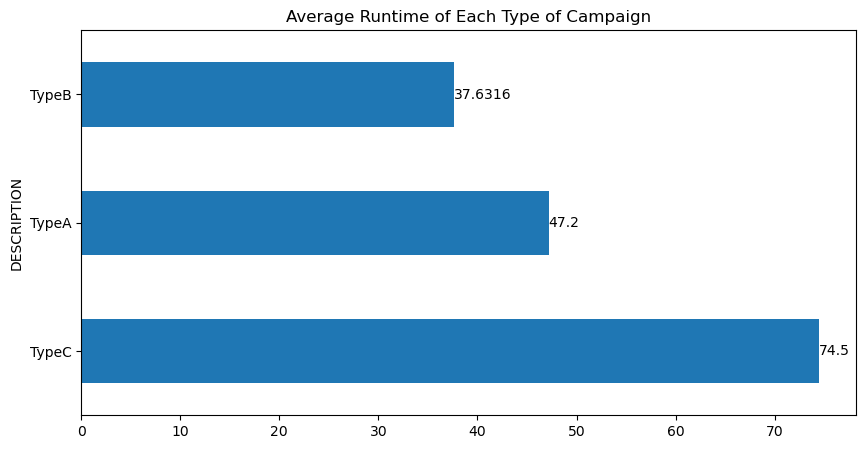

In [17]:
plt.figure(figsize=(10,5))
ax = campaign_desc.groupby('DESCRIPTION')['DURATION'].mean().sort_values(ascending=False).plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.title('Average Runtime of Each Type of Campaign')
plt.show()

3) On average, TypeB campaigns run the shortest, for 37.6 days, and TypeC campaigns run the longest, for 74.5 days.

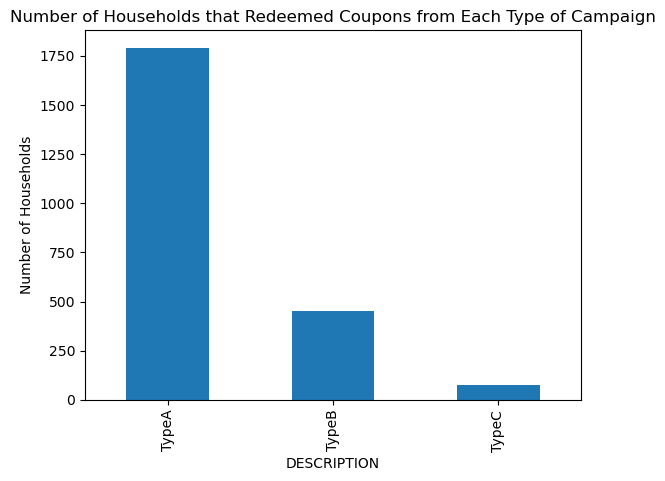

In [18]:
# Campaign-wise Coupon Redemption:
campaign_wise_coupon_redemption=pd.merge(campaign_desc[['DESCRIPTION','CAMPAIGN']],coupon_redempt[['household_key','CAMPAIGN']],on='CAMPAIGN')
campaign_wise_coupon_redemption.groupby('DESCRIPTION')['household_key'].count().plot(kind='bar')
plt.title('Number of Households that Redeemed Coupons from Each Type of Campaign')
plt.ylabel('Number of Households')
plt.show()

4. TypeA was the most popular type of Campaign

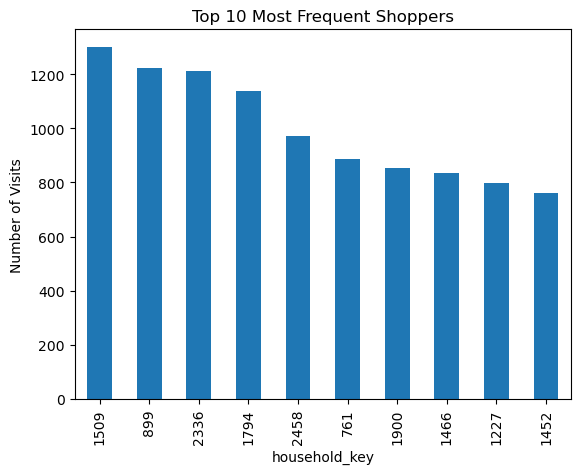

In [19]:
no_of_visits.sort_values('no_of_visits',ascending=False)[:10]['no_of_visits'].plot(kind='bar')
plt.title('Top 10 Most Frequent Shoppers')
plt.ylabel('Number of Visits')
plt.xlabel('household_key')
plt.show()

<a id="finaldf"> </a>
## 6. Assembling the Final Dataframe:

Assembling the Final Dataframe by joining all the features obtained during feature engineering to hh_demographic table to build our required model.

Features Engineered:
* no_campaigns_household_targeted
* distinct_coupons_redeemed_household
* coupon_success_ratio
* no_of_items_per_visit
* no_of_visits
* total_amount_per_visit


In [20]:
print(no_campaigns_household_targeted.shape)
print(distinct_coupons_redeemed_household.shape)
print(coupon_success_ratio.shape)
print(avg_no_of_items_per_household_per_visit.shape)
print(no_of_visits.shape)
print(avg_amount_per_household_per_visit.shape)

(2500, 2)
(434, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)


In [21]:
coupon_success_ratio.columns

Index(['household_key', 'coupon_success_ratio'], dtype='object')

In [22]:
df = hh_demographic.copy()

# Adding all the engineered features:
df = pd.merge(df,no_campaigns_household_targeted,on='household_key',how='left')
df = pd.merge(df,distinct_coupons_redeemed_household,on='household_key',how='left')
df = pd.merge(df,coupon_success_ratio,on='household_key',how='left')
df = pd.merge(df,avg_no_of_items_per_household_per_visit,on='household_key',how='left')
df = pd.merge(df,no_of_visits,on='household_key',how='left')
df = pd.merge(df,avg_amount_per_household_per_visit,on='household_key',how='left')
df.set_index('household_key',inplace=True)
df

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,Redeemed,no_campaigns_household_targeted,distinct_coupons_redeemed_household,coupon_success_ratio,avg_no_of_items_per_household_per_visit,no_of_visits,avg_amount_per_household_per_visit
household_key,,,,,,,,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,8.0,2.0,0.25,23.0,86,50.350698
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,0,4.0,NaN,0.00,26.0,59,57.627966
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,1,10.0,1.0,0.10,605.0,113,48.982035
13,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,1,10.0,7.0,0.70,6778.0,275,47.966982
16,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,0,2.0,NaN,0.00,829.0,98,15.428776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.0,1.0,0.50,1654.0,35,60.598000
2496,45-54,A,75-99K,Homeowner,Unknown,3,1,1,5.0,3.0,0.60,2068.0,63,68.883492
2497,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,0,3.0,NaN,0.00,277.0,221,32.180905


<a id="clean"> </a>
## 7. Preliminary Data Cleaning:

<a id="null"> </a>
### 7.1. Null Values:

### Checking for  Null Values:

In [23]:
df.isnull().sum()

AGE_DESC                                     0
MARITAL_STATUS_CODE                          0
INCOME_DESC                                  0
HOMEOWNER_DESC                               0
HH_COMP_DESC                                 0
HOUSEHOLD_SIZE_DESC                          0
KID_CATEGORY_DESC                            0
Redeemed                                     0
no_campaigns_household_targeted              0
distinct_coupons_redeemed_household        490
coupon_success_ratio                        41
avg_no_of_items_per_household_per_visit      0
no_of_visits                                 0
avg_amount_per_household_per_visit           0
dtype: int64

In [24]:
# The null values come from households that didn't redeem coupons, so let us take care of that 

In [25]:
df.fillna(0, inplace=True)

In [26]:
# We need to take into consideration only the households that actually received campaigns:
df=df[df['no_campaigns_household_targeted'] != 0]

In [27]:
df.shape

(760, 14)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 1 to 2499
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   AGE_DESC                                 760 non-null    object 
 1   MARITAL_STATUS_CODE                      760 non-null    object 
 2   INCOME_DESC                              760 non-null    object 
 3   HOMEOWNER_DESC                           760 non-null    object 
 4   HH_COMP_DESC                             760 non-null    object 
 5   HOUSEHOLD_SIZE_DESC                      760 non-null    object 
 6   KID_CATEGORY_DESC                        760 non-null    object 
 7   Redeemed                                 760 non-null    int64  
 8   no_campaigns_household_targeted          760 non-null    float64
 9   distinct_coupons_redeemed_household      760 non-null    float64
 10  coupon_success_ratio                     760 non-

<a id="catlabel"> </a>
### 7.2. Categorical Labels:

In [29]:
# Some of the Categorical labels are encoded. Let us rename these labels.
df['MARITAL_STATUS_CODE']=df['MARITAL_STATUS_CODE'].map({'A':'Married','B':'Single','U':'Unknown'})
df['KID_CATEGORY_DESC'].replace(to_replace='None/Unknown',value='0',inplace=True)

<a id="uni"> </a>
## 8. Univariate Analysis:

In [30]:
df_num=df.select_dtypes(np.number)
df_cat=df.select_dtypes('object')

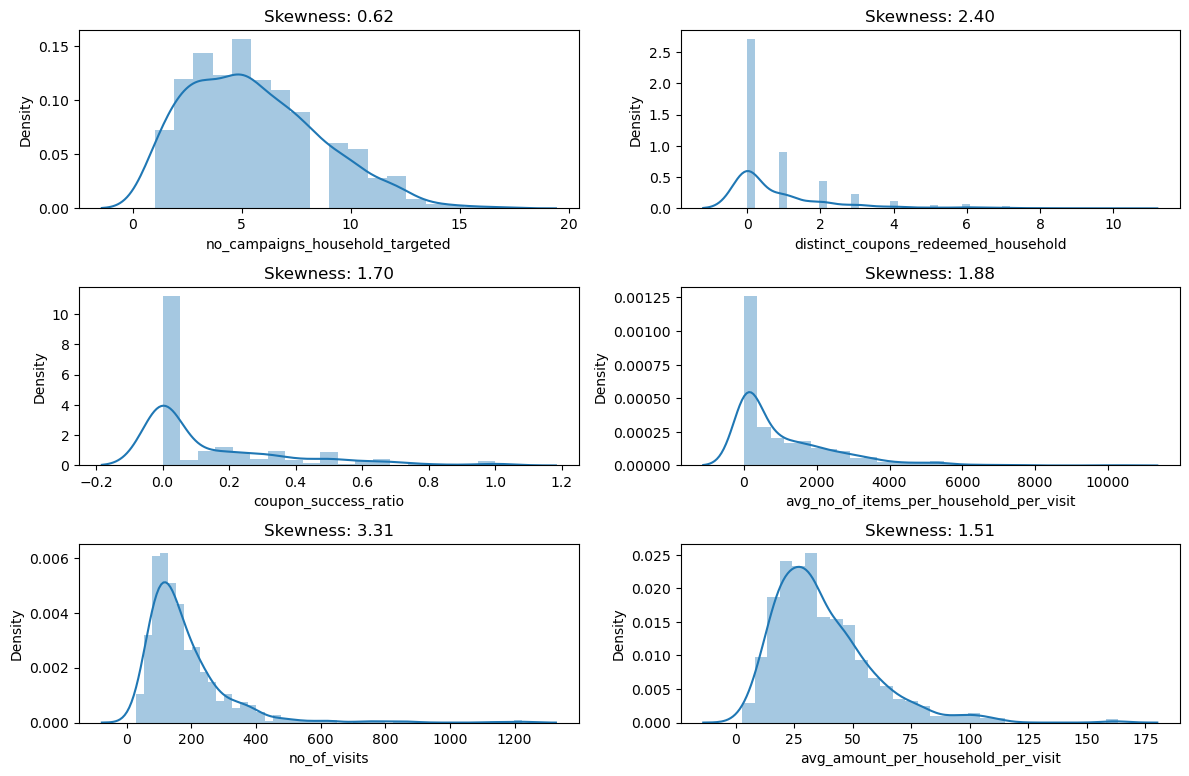

In [31]:
plt.figure(figsize=(12,10))
j=1
for i in df_num.columns[1:]:
    plt.subplot(len(df_num.columns)//2+1,2,j)
    sns.distplot(df_num[i],hist=True)
    plt.title('Skewness: %0.2f'%(df_num[i].skew()))
    j+=1
plt.tight_layout()    
plt.show()

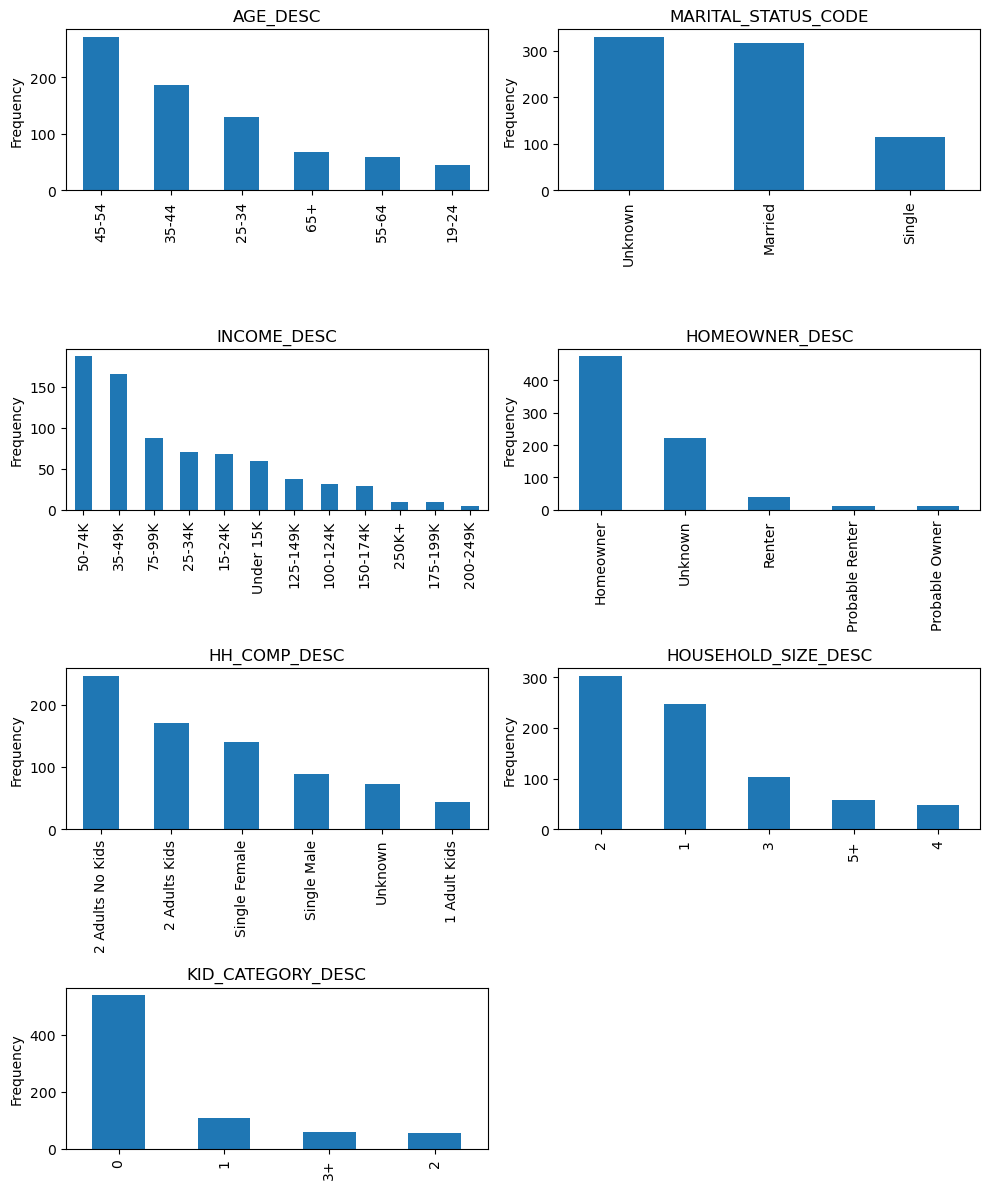

In [32]:
plt.figure(figsize=(10,12))
j=1
for i in df_cat.columns:
    plt.subplot(len(df_cat.columns)//2+1,2,j)
    df[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.ylabel('Frequency')
    j+=1
plt.tight_layout()
plt.show()

<a id="bi"> </a>
## 9. Bivariate Analysis

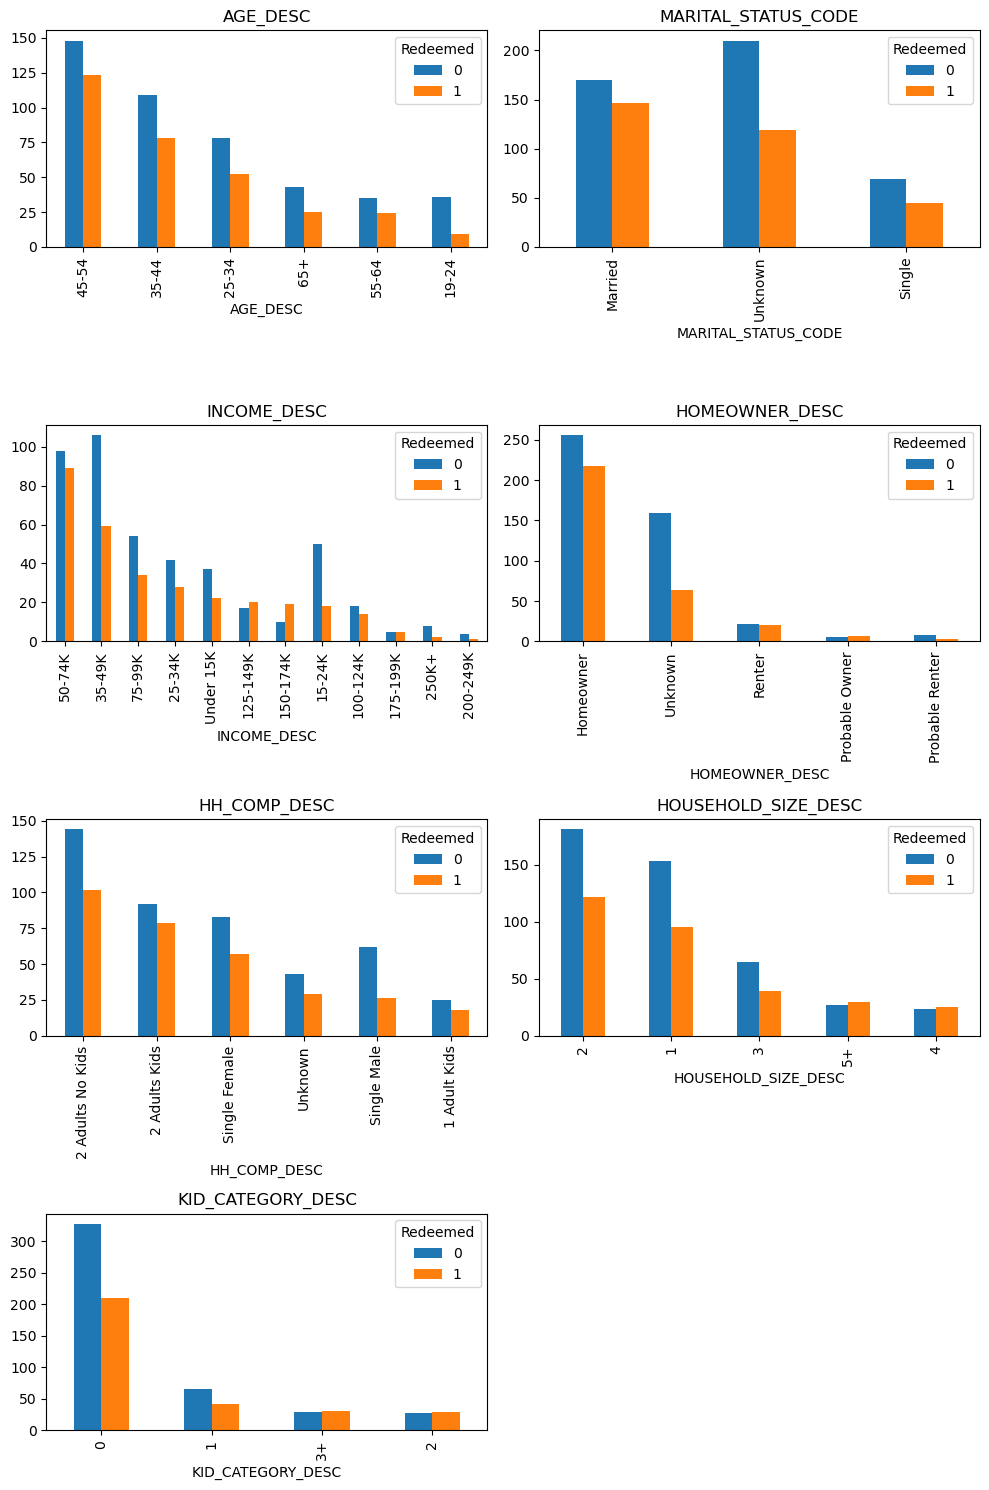

In [33]:
# Categorical Variables vs Target Variable:

plt.figure(figsize=(10,15))
j=1
for i in df_cat.columns:
    ax = plt.subplot(len(df_cat.columns)//2+1,2,j)
    pd.crosstab(df_cat[i],df['Redeemed']).sort_values(by=1,ascending=False).plot(kind='bar',ax=ax)
    plt.title(i)
    j+=1
plt.tight_layout()
plt.show()

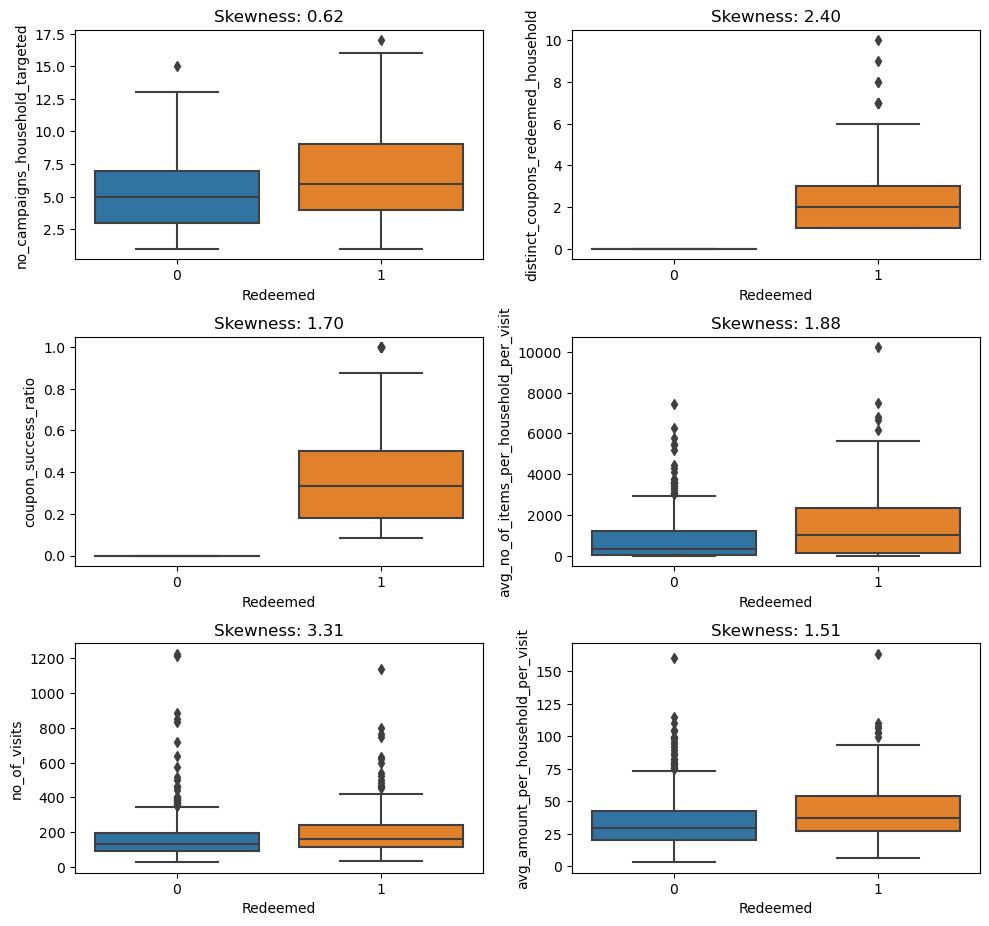

In [34]:
# Numberical Variables vs Target Variable:

plt.figure(figsize=(10,12))
j=1
for i in df_num.columns[1:]:
    plt.subplot(len(df_num.columns)//2+1,2,j)
    sns.boxplot(x=df['Redeemed'],y=df_num[i])
    plt.title('Skewness: %0.2f'%(df_num[i].skew()))
    j+=1
plt.tight_layout(h_pad=1)
plt.show()

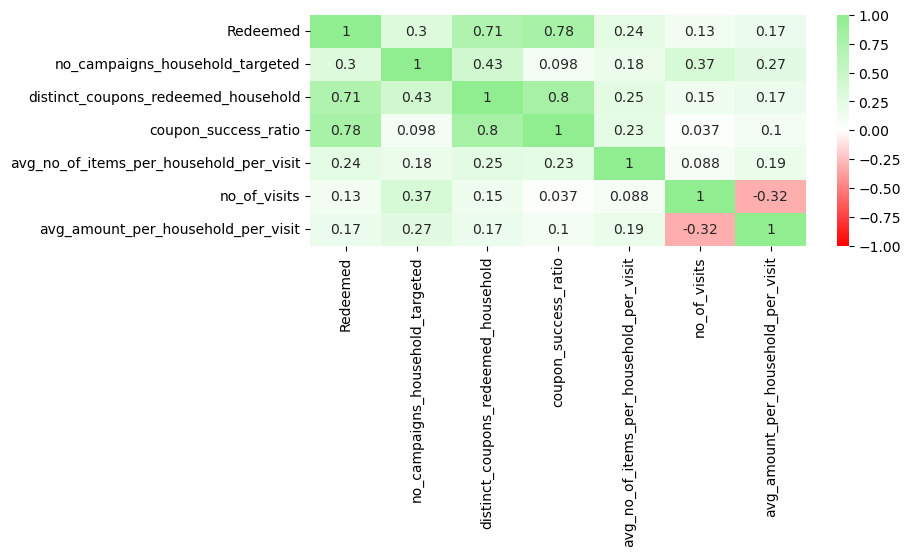

In [35]:
# Heat Map of Correlation Matrix Before Scaling the Numerical Variables and
# Encoding the Categorical Variables:

# Importing LinearSegmentedColormap to create a custom cmap:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(8,3))
cmap = LinearSegmentedColormap.from_list('', ['red', 'white', 'lightgreen'])
sns.heatmap(df.corr(),cmap=cmap,annot=True,vmin=-1,vmax=+1,center=0)
plt.show()

<a id="advclean"> </a>
## 10. Advanced Data Cleaning:

<a id="outliers"> </a>
### 10.1. Outlier Treatment:

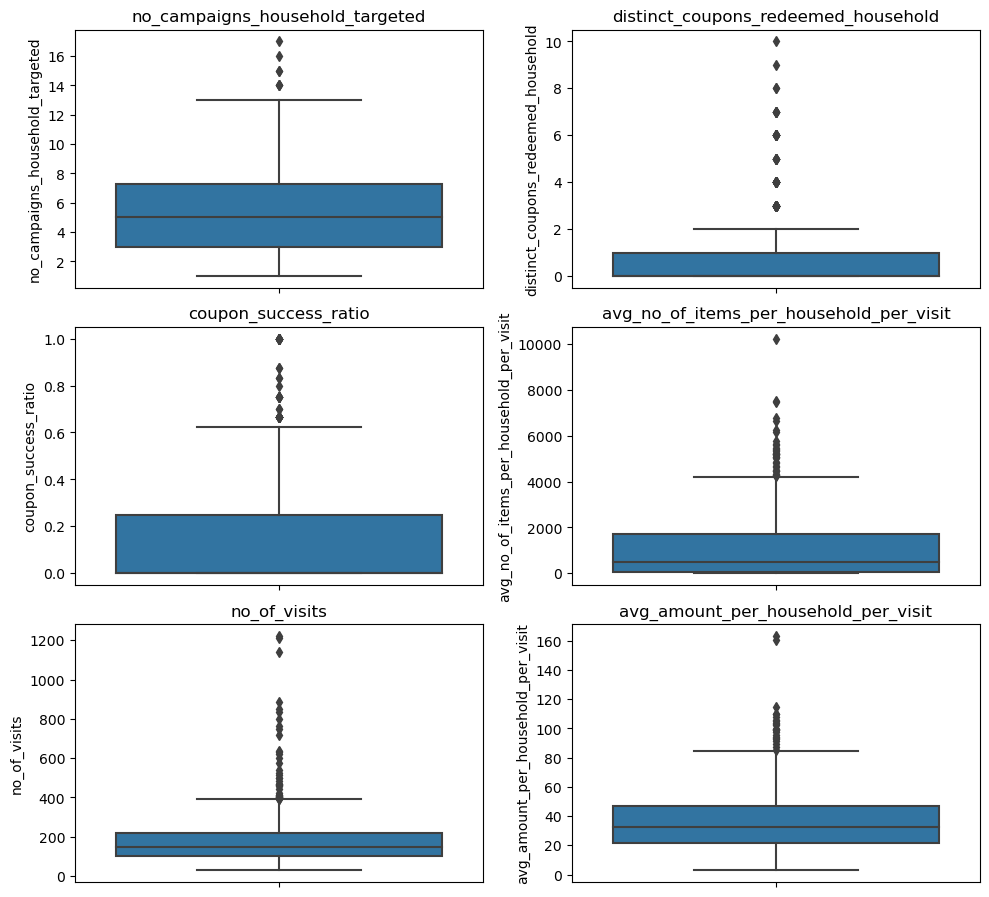

In [36]:
# Checking for outliers:
plt.figure(figsize=(10,12))
j=1
for i in df_num.columns[1:]:
    plt.subplot(len(df_num.columns)//2+1,2,j)
    sns.boxplot(y=df_num[i])
    plt.title(i)
    j+=1
plt.tight_layout(h_pad=1)
plt.show()

In [37]:
# Treating the Outliers using IQR method:
df_outliers_treated = df.copy()
for column in df_num.drop('Redeemed',axis=1).columns:
    Q3 = df[column].quantile(0.75)
    Q1 = df[column].quantile(0.25)
    IQR = (Q3 - Q1)
    UL = Q3 + (1.5*IQR)
    LL = Q1 - (1.5*IQR)
    df_outliers_treated[column] = df_outliers_treated[column].apply(lambda x: UL if x > UL else LL if x < LL else x)

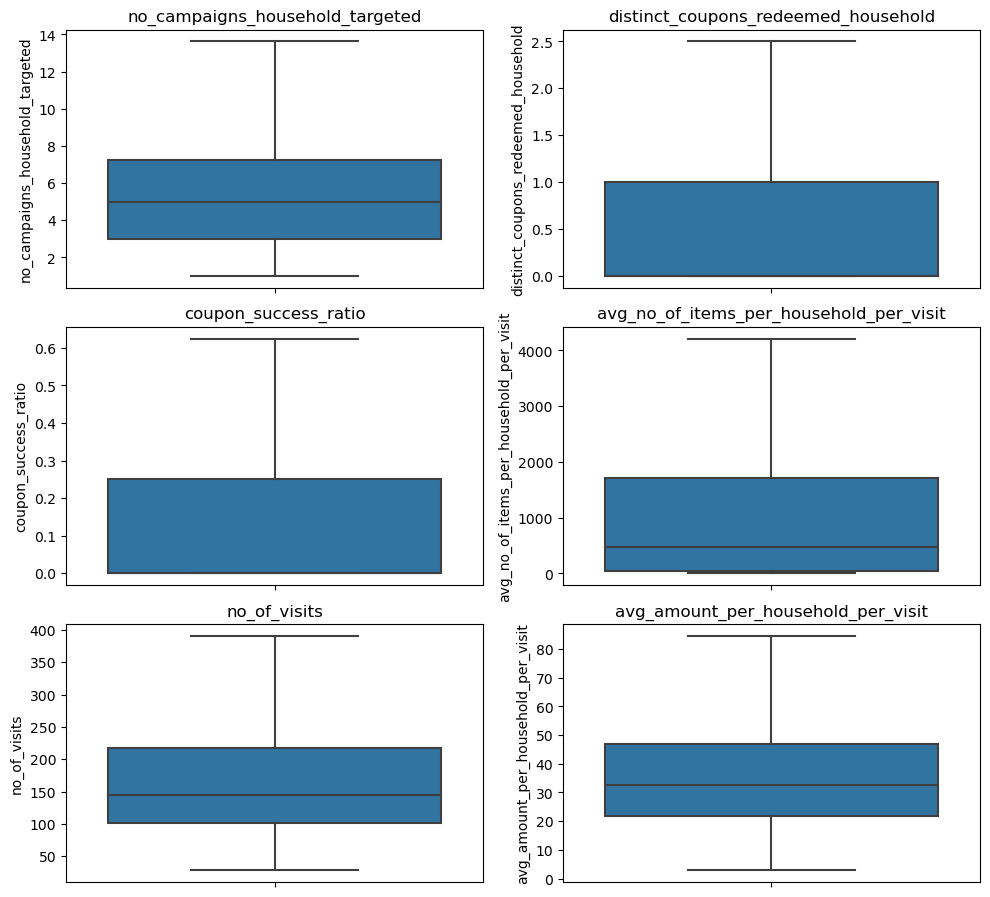

In [38]:
# Checking if the Outlier Treatment worked:
plt.figure(figsize=(10,12))
j=1
for i in df_num.columns[1:]:
    plt.subplot(len(df_num.columns)//2+1,2,j)
    sns.boxplot(y=df_outliers_treated[i])
    plt.title(i)
    j+=1
plt.tight_layout(h_pad=1)
plt.show()

<a id="split"> </a>
## 11. Train-Test Split:

In [39]:
X = df_outliers_treated.drop('Redeemed',axis=1)
y = df_outliers_treated['Redeemed']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 69, stratify=y)

<a id="scalenc"> </a>

## 12. Scaling and Encoding:

In [40]:
# Splitting up the numerical and categorical variables:
X_train_num = X_train.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes('object')

# Scaling the numerical variables:
ss = StandardScaler()
X_train_num = pd.DataFrame(ss.fit_transform(X_train_num), columns=X_train_num.columns)

# Encoding the categorical variables:
X_train_cat = pd.get_dummies(X_train_cat,drop_first=True)
X_train_cat.reset_index(inplace=True, drop=True)

# Putting together the final dataframe:
X_train_scaled = pd.concat([X_train_num, X_train_cat],axis=1)
# X_train_scaled

# Doing the same thing for the test set:
X_test_num = X_test.select_dtypes(np.number)
X_test_cat = X_test.select_dtypes('object')
X_test_num = pd.DataFrame(ss.transform(X_test_num), columns=X_test_num.columns)
X_test_cat = pd.get_dummies(X_test_cat,drop_first=True)
X_test_cat.reset_index(inplace=True, drop=True)
X_test_scaled = pd.concat([X_test_num, X_test_cat],axis=1)

# Now we have to reset the indices of y:
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [41]:
df_scaled = pd.concat([pd.concat([X_train_scaled, X_test_scaled],axis=0), pd.concat([y_train, y_test],axis=0)],axis=1)

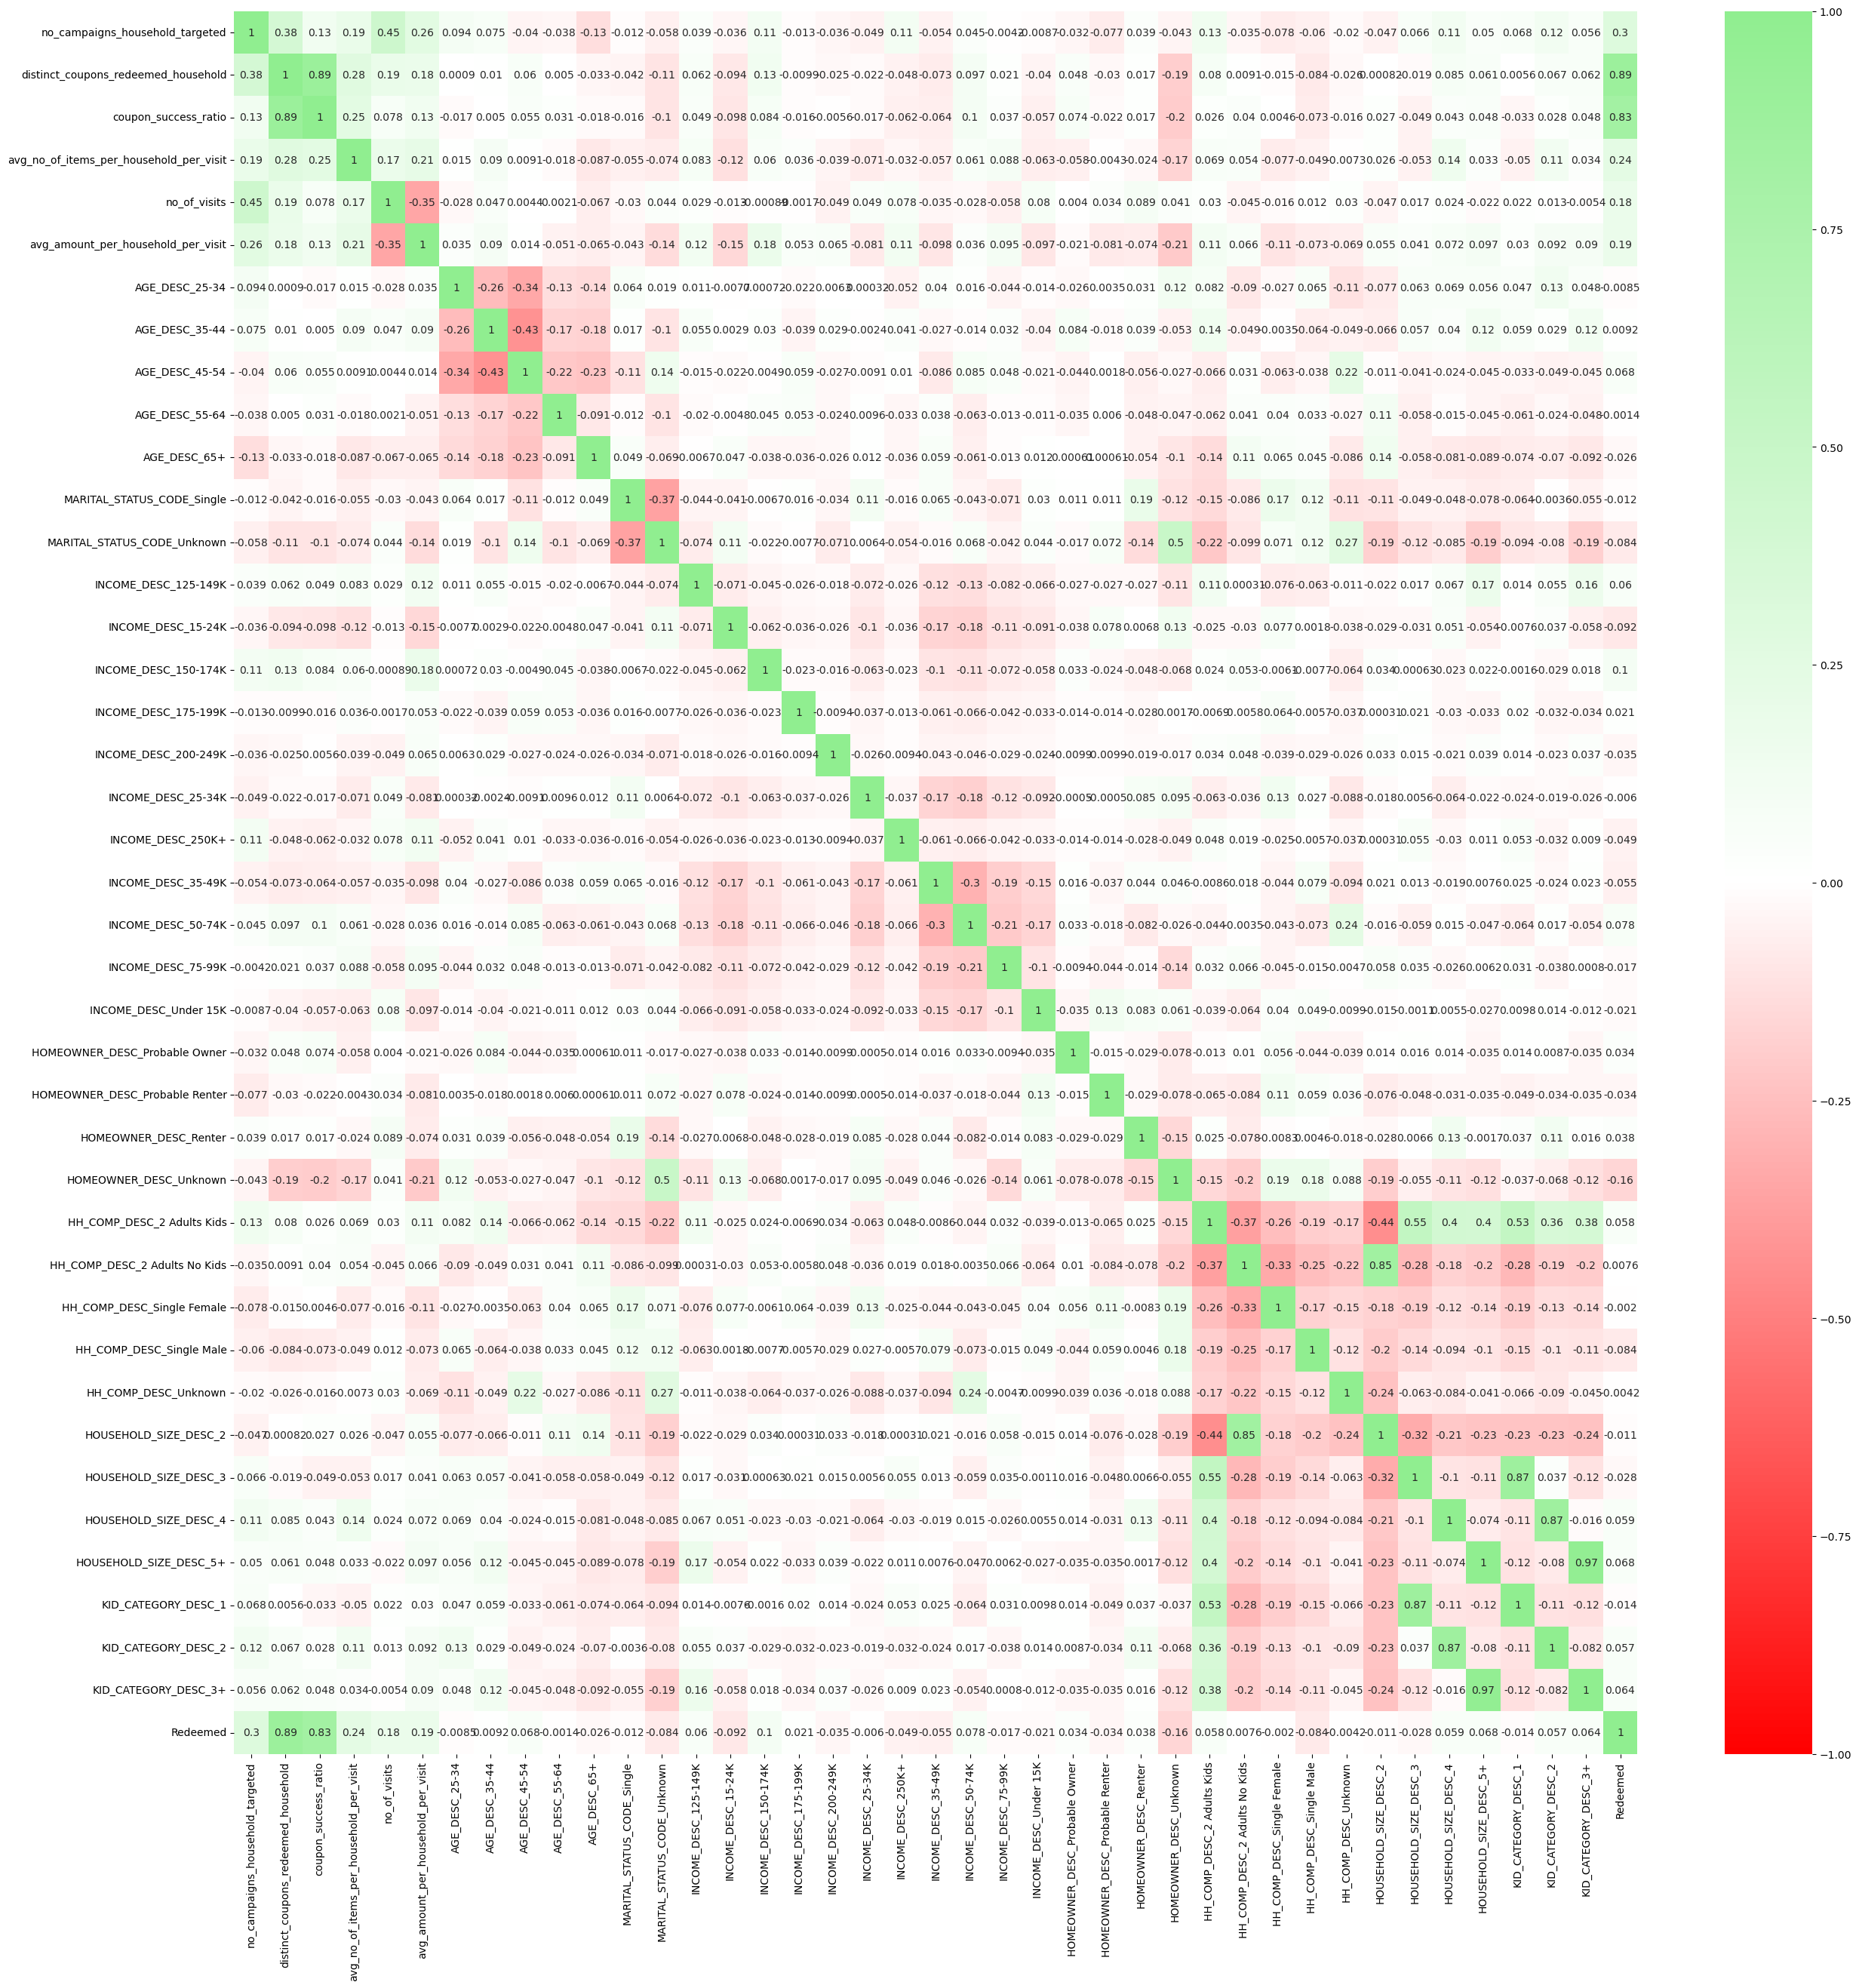

In [42]:
# Heat Map of Correlation Matrix After Scaling the Numerical Variables and
# Encoding the Categorical Variables:

# from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(30,30))
cmap = LinearSegmentedColormap.from_list('', ['red', 'white', 'lightgreen'])
sns.heatmap(df_scaled.corr(),cmap=cmap,annot=True,vmin=-1,vmax=+1,center=0)
plt.show()

In [43]:
# We can see that there is strong correlation among some of the features.
# This may affect our linear model.

<a id="model"> </a>
## 13. Model Building:

<a id="logit"> </a>

### 13.1  Base Model - Logistic Regression:

In [44]:
base_model_logit = Logit(y_train, sm.add_constant(X_train_scaled)).fit()

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [45]:
# We can see that there is some multicollinearity among the features:

<a id="vif"> </a>
#### 13.1.1.  Treating Multicollinearity using VIF Method:

In [46]:
# Creating a user-defined function to calculate VIF table:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data
X_vif = X_train_scaled.copy()
VIF_initial = calculate_vif(X_vif)
updated_VIF = calculate_vif(X_vif)
vif_threshold = 10
drop_list =[]

# Recursively dropping columns that exceed VIF threshold until multicollinearity is treated:
while updated_VIF['VIF'].max()>vif_threshold:
    vif_index = updated_VIF['VIF'].idxmax()
    variable_to_drop = updated_VIF.loc[vif_index, 'Variable']
    drop_list.append(variable_to_drop)
    X_vif = X_vif.drop(variable_to_drop, axis=1)
    updated_VIF = calculate_vif(X_vif)

In [47]:
# VIF Table:
updated_VIF.sort_values(by='VIF', ascending=False)

,Variable,VIF
33,HOUSEHOLD_SIZE_DESC_3,8.695671
1,distinct_coupons_redeemed_household,8.167397
35,KID_CATEGORY_DESC_1,7.470987
2,coupon_success_ratio,7.163104
32,HOUSEHOLD_SIZE_DESC_2,6.975561
36,KID_CATEGORY_DESC_2,6.845269
34,HOUSEHOLD_SIZE_DESC_4,6.584372
8,AGE_DESC_45-54,6.295794
21,INCOME_DESC_50-74K,6.022648
28,HH_COMP_DESC_2 Adults Kids,5.438511


In [48]:
# The final features that contribute only an acceptable amount to multicollinearity:
vif_features = updated_VIF.sort_values(by='VIF', ascending=False)['Variable']

In [49]:
# Training the Logistic Regression Model only on the final features: 
X_train_scaled_vif = X_train_scaled[vif_features]
X_test_scaled_vif = X_test_scaled[vif_features]

base_model_logit = Logit(y_train, sm.add_constant(X_train_scaled_vif)).fit()
print(base_model_logit.summary())

         Current function value: 0.105389
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Redeemed   No. Observations:                  570
Model:                          Logit   Df Residuals:                      531
Method:                           MLE   Df Model:                           38
Date:                Thu, 04 Jan 2024   Pseudo R-squ.:                  0.8442
Time:                        18:12:27   Log-Likelihood:                -60.072
converged:                      False   LL-Null:                       -385.55
Covariance Type:            nonrobust   LLR p-value:                1.228e-112
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      13.3265   3103.235      0.004      0.997   

C:\Users\Galahad38\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
lr = LogisticRegression()
base_model_lr = lr.fit(X_train_scaled_vif, y_train)

In [51]:
y_pred_lr = base_model_lr.predict(X_test_scaled_vif)
print('Classification Report for Logistic Regression:\n',classification_report(y_true=y_test,y_pred=y_pred_lr))

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00        78

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



<a id="knn"> </a>

### 13.2  K-Nearest Neighbors:

In [52]:
knn = KNeighborsClassifier()
base_model_knn = knn.fit(X_train_scaled, y_train)
y_pred_knn = base_model_knn.predict(X_test_scaled)
print('Classification Report for K-Nearest Neigbors:\n',classification_report(y_true=y_test,y_pred=y_pred_knn))

Classification Report for K-Nearest Neigbors:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       112
           1       1.00      0.91      0.95        78

    accuracy                           0.96       190
   macro avg       0.97      0.96      0.96       190
weighted avg       0.97      0.96      0.96       190



<a id="dt"> </a>

### 13.3  Decision Tree Classifier:

In [53]:
dt = DecisionTreeClassifier()
base_model_dt = dt.fit(X_train_scaled, y_train)
y_pred_dt = base_model_dt.predict(X_test_scaled)
print('Classification Report for Decision Tree Classifier:\n',classification_report(y_true=y_test,y_pred=y_pred_dt))

Classification Report for Decision Tree Classifier:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00        78

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



<a id="rf"> </a>

### 13.4  Random Forest Classifier:

In [54]:
rf = RandomForestClassifier()
base_model_rf = rf.fit(X_train_scaled, y_train)
y_pred_rf = base_model_rf.predict(X_test_scaled)
print('Classification Report for Random Forest Classifier:\n',classification_report(y_true=y_test,y_pred=y_pred_rf))

Classification Report for Random Forest Classifier:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00        78

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



<a id="gnb"> </a>

### 13.5  Naive Bayes Classifier:

In [55]:
gnb = GaussianNB()
base_model_gnb = gnb.fit(X_train_scaled, y_train)
y_pred_gnb = base_model_gnb.predict(X_test_scaled)
print('Classification Report for Naive Bayes Classifier:\n',classification_report(y_true=y_test,y_pred=y_pred_gnb))

Classification Report for Naive Bayes Classifier:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       112
           1       0.95      1.00      0.97        78

    accuracy                           0.98       190
   macro avg       0.98      0.98      0.98       190
weighted avg       0.98      0.98      0.98       190

